In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j]:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        
        
    
    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A,B,E =padding(7,1)

print(E)

(312, 312)
[[ 1.47079090e+00 -3.80735100e-01  9.00669460e-01 ... -1.51669620e-01
   5.92808700e-01  3.62761300e-01]
 [-1.22160690e-03 -5.55376650e-01  2.18429260e+00 ... -1.94850480e+00
   1.24024255e-02  1.23071940e+00]
 [-3.82744700e-02 -9.16088000e-01  1.66693190e+00 ... -6.68783800e-01
   5.46813100e-01  6.99725300e-01]
 ...
 [ 1.65866240e+00 -3.93733650e-01  1.06404030e+00 ...  1.37551920e-01
  -6.15018250e-01  1.99109910e+00]
 [-4.76618560e-01 -8.66642240e-01  4.86733560e-01 ... -5.09190800e-01
   1.40490380e+00  1.16904460e+00]
 [ 3.57302200e-01 -1.05386630e+00  7.62425440e-02 ... -1.90720360e+00
  -1.06275690e+00  1.18645610e+00]]


In [4]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
maxlen=np.max(lenA)
print(maxlen)

312 1
168 2
177 3
294 4
213 5
251 6
213 7
148 8
291 9
254 10
378 11
222 12
174 13
222 14
378


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    np.savetxt('./'+str(run)+'/'+'embed.txt', b[:,1:])
    
    
    
    ##remove below if n2v is used
    
    
    #b = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #b = b.T[:,0:3]
    
    #print(i)
    #print(b)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    padding(maxlen,run)
    

(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[ 0.5060553   0.2818542  -0.69770336  0.55112785 -0.5215664   0.2899595
  0.30692217  0.08981479  0.3454369   0.5276049   0.5764146   0.45654616
  0.53778476  0.7512141   0.50152093  0.6800905   1.4122944   1.0762792
  0.34810945  1.2132851  -0.01952898  1.1895902   1.0524558   0.9248265
  0.8069007   1.1831782  -0.36181286 -0.7001086   1.0340841   0.63128483
  0.8963777   0.61909235 -0.875795    0.96744555  0.3229979   0.15670884
 -0.4097579   0.69185066  0.39620966  0.05316508 -0.14512207 -0.43434867
  0.17536272  0.94981736  0.1823784  -0.3916905   0.75083876  0.09866873
 -0.37989447  0.0635443  -0.3500757  -0.7497959   0.8708252   0.45858136
 -0.22649157  0.30947328 -0.15944922 -0.7151233   0.58272016 -0.1113029
  0.04908838 -0.34020835  1.0501322   0.34005475  0.99774885 -0.03723221
 -0.2653867   0.2721236   0.2872238   0.67772686  0.11774658  0.38242364
  0.70718086 -0.00995535  0.42449483  0.46151814  0.09851625  0.35595563
  0.79939675  0.284119    0.34692916  1.0327784   0.394

<IPython.core.display.Javascript object>


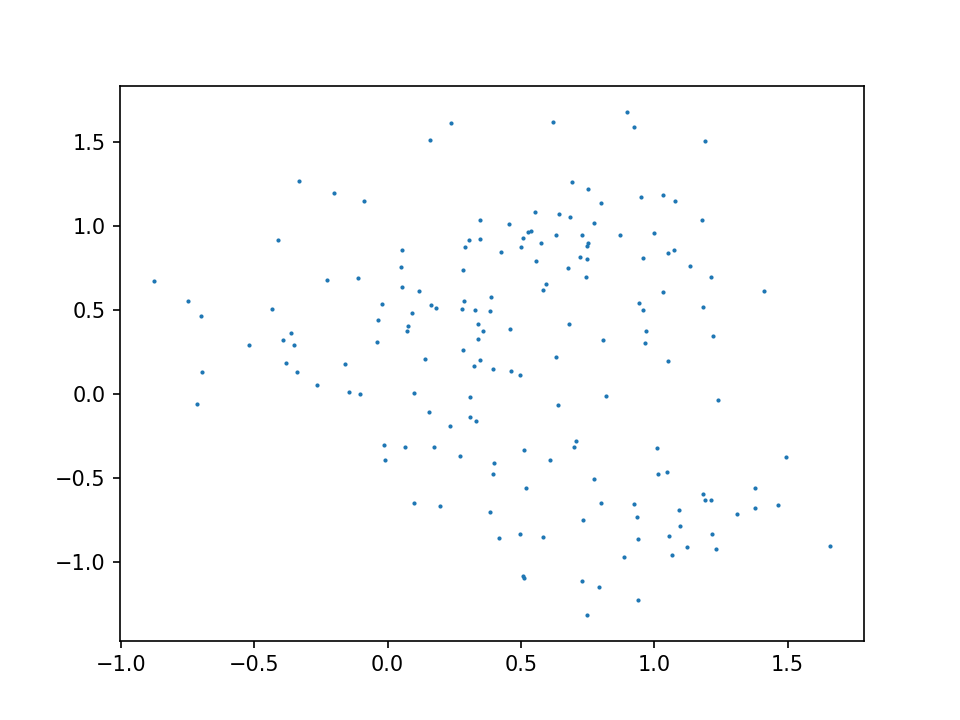

In [6]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


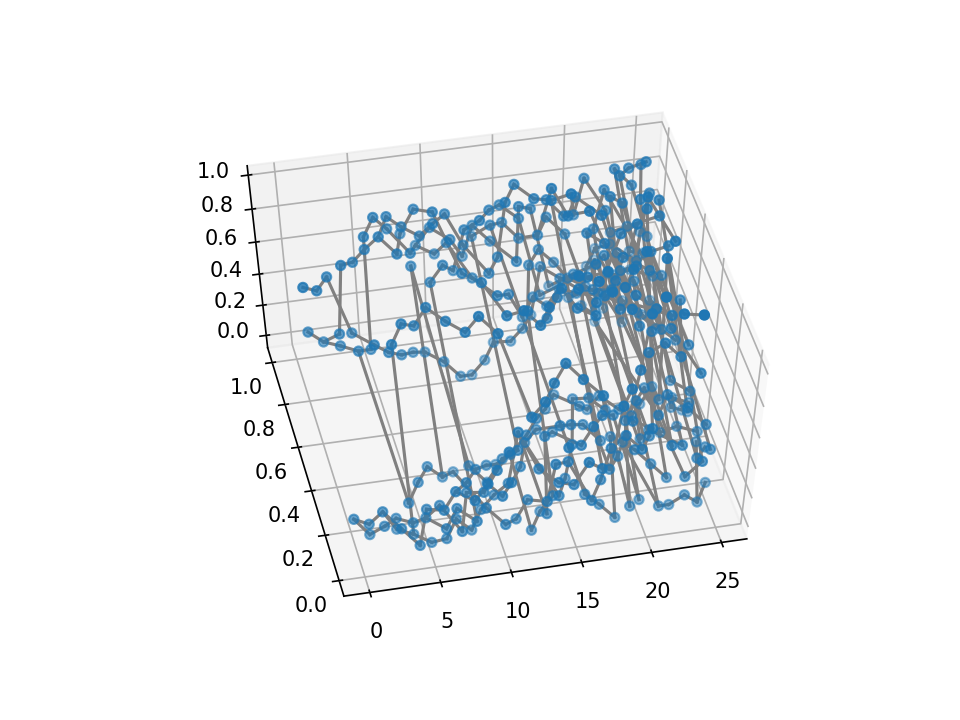

1.0 5.0
[0.5081162324649299, 0.4382164401211746]
2.0 7.0
[0.758817635270541, 0.6933544847332462]
3.0 4.0
[0.1221442885771543, 0.08924542962874486]
3.0 6.0
[0.1221442885771543, 0.01644542962874486]
4.0 9.0
[0.08924542962874486, 0.15922843603567255]
5.0 10.0
[0.4382164401211746, 0.4573824806201758]
5.0 11.0
[0.4382164401211746, 0.5329824806201758]
6.0 12.0
[0.01644542962874486, 0.08480069135536908]
7.0 8.0
[0.6933544847332462, 0.6759120461338386]
8.0 14.0
[0.6759120461338386, 0.4742795416006503]
9.0 13.0
[0.15922843603567255, -0.011637479639303998]
9.0 15.0
[0.15922843603567255, 0.11981337312622899]
10.0 17.0
[0.4573824806201758, 0.4945847366067455]
11.0 18.0
[0.5329824806201758, 0.7454377832466548]
12.0 16.0
[0.08480069135536908, 0.064802520360696]
13.0 19.0
[-0.011637479639303998, 0.004680832933577489]
14.0 22.0
[0.4742795416006503, 0.5592352025752381]
15.0 21.0
[0.11981337312622899, 0.07478074044453442]
16.0 20.0
[0.064802520360696, 0.0849428329335775]
17.0 23.0
[0.4945847366067455, 0

263.0 290.0
[0.1735356309404001, 0.35779094530045835]
264.0 280.0
[0.18931461570791994, 0.12500720708670954]
265.0 288.0
[0.3676922435048895, 0.38148212703857476]
266.0 292.0
[0.7786268485854662, 0.24760095094040008]
267.0 291.0
[0.8259916820717887, 0.741867343984953]
268.0 289.0
[0.33249358756260977, 0.30915134218847246]
269.0 294.0
[0.8665689946215281, 0.5817531366016857]
270.0 293.0
[0.6159229734472633, 0.87797620708919]
271.0 285.0
[0.3859892345448448, 0.8234565234397101]
272.0 278.0
[0.7552966193833118, 0.6156666686859542]
273.0 297.0
[0.6828971242153118, 0.380347133264406]
274.0 296.0
[0.6777352908599407, 0.8343451106127814]
275.0 284.0
[0.17917058646428735, 0.15091390340477967]
276.0 308.0
[0.7286009710062701, 0.4622317618407592]
277.0 299.0
[0.8180419114949098, 0.5134942009315376]
278.0 316.0
[0.6156666686859542, 0.6587261364493939]
279.0 317.0
[0.13724735199177773, 0.31893362052567353]
280.0 303.0
[0.12500720708670954, 0.8836083155830039]
281.0 302.0
[0.8042068484594673, 0.870

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

run=11

x,y,r,ide,split_id,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5), unpack=True)

id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    #ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

blue


<IPython.core.display.Javascript object>


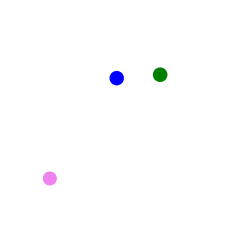

c_full ['blue', 'green', 'violet']


<IPython.core.display.Javascript object>


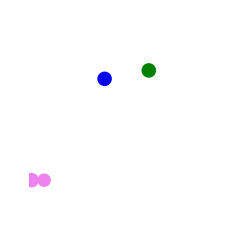

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'green' 'violet']
c ['green']


<IPython.core.display.Javascript object>


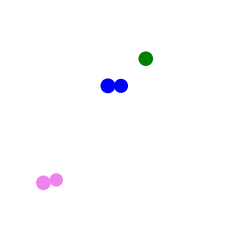

c_full ['violet', 'blue', 'violet', 'green']
prev_c ['violet' 'blue' 'violet' 'green']
c ['green']
prev_c ['violet' 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'green']
c ['violet']


<IPython.core.display.Javascript object>


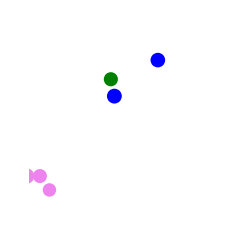

c_full ['green', 'violet', 'blue', 'blue', 'violet']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['green']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['violet']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['blue']
prev_c ['green' 'violet' 'blue' 'blue' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


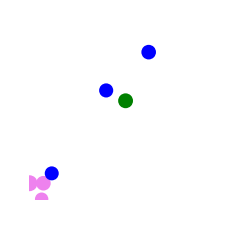

c_full ['violet', 'green', 'violet', 'violet', 'blue', 'blue']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['green']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'green' 'violet' 'violet' 'blue' 'blue']
c ['blue']


<IPython.core.display.Javascript object>


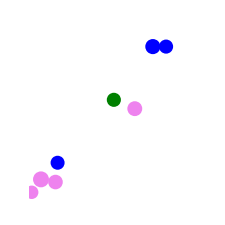

c_full ['violet', 'violet', 'violet', 'green', 'blue', 'blue', 'blue']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['green']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'green' 'blue' 'blue' 'blue']
c ['violet']


<IPython.core.display.Javascript object>


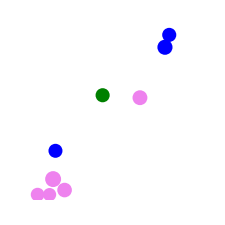

c_full ['blue', 'violet', 'violet', 'green', 'blue', 'blue', 'violet', 'violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['green']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'violet' 'green' 'blue' 'blue' 'violet' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


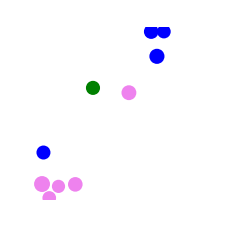

c_full ['green', 'blue', 'violet', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['green']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['blue']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['green' 'blue' 'violet' 'violet' 'violet' 'v

<IPython.core.display.Javascript object>


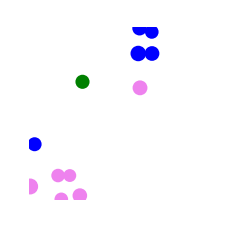

c_full ['violet', 'violet', 'blue', 'violet', 'green', 'blue', 'blue', 'violet', 'violet', 'blue']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['green']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['blue']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['violet']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['blue']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'violet'
 'blue']
c ['blue']
prev_c ['violet' 'violet' 'blue' 'violet' 'green' 'blue' 'blue' 'violet' 'vi

<IPython.core.display.Javascript object>


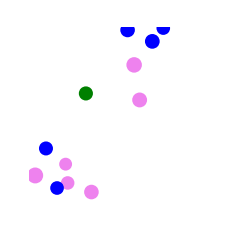

c_full ['violet', 'green', 'violet', 'blue', 'violet', 'violet', 'blue', 'blue', 'blue', 'violet', 'violet', 'blue']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['green']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue' 'blue'
 'violet' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'green' 'violet' 'blue' 'violet

<IPython.core.display.Javascript object>


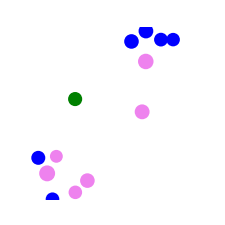

c_full ['violet', 'blue', 'green', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'blue', 'violet', 'blue']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'green' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'green' 'violet' 'violet'

<IPython.core.display.Javascript object>


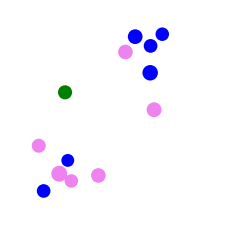

c_full ['blue', 'violet', 'blue', 'violet', 'violet', 'blue', 'violet', 'blue', 'violet', 'blue', 'violet', 'blue', 'green']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet'
 'blue' 'violet' 'blue' 'green']
c ['blue

<IPython.core.display.Javascript object>


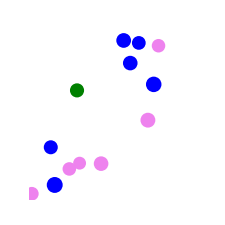

c_full ['blue', 'violet', 'green', 'blue', 'blue', 'blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'blue', 'violet']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet'
 'violet' 'violet' 'blue' 'violet']
c ['vio

<IPython.core.display.Javascript object>


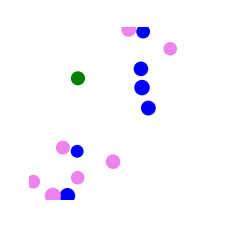

c_full ['violet', 'blue', 'violet', 'blue', 'blue', 'blue', 'violet', 'blue', 'green', 'violet', 'violet', 'blue', 'violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['green']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'violet' 'blue' 'green'
 'violet' 'violet' 'blue' 'violet']
c ['vi

<IPython.core.display.Javascript object>


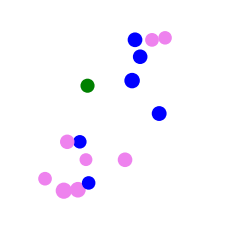

c_full ['violet', 'blue', 'blue', 'violet', 'green', 'blue', 'violet', 'blue', 'blue', 'blue', 'violet', 'violet', 'violet', 'violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'blue'
 'blue' 'violet' 'violet' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'green' 'blue

<IPython.core.display.Javascript object>


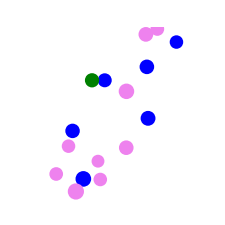

c_full ['violet', 'violet', 'violet', 'blue', 'blue', 'violet', 'violet', 'violet', 'blue', 'green', 'violet', 'blue', 'blue', 'blue', 'violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c ['green']
prev_c ['violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'green' 'violet' 'blue' 'blue' 'blue' 'violet']
c [

<IPython.core.display.Javascript object>


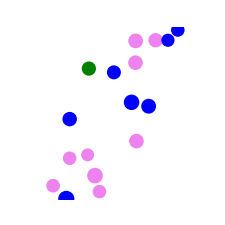

c_full ['blue', 'violet', 'blue', 'violet', 'green', 'blue', 'violet', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'violet']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'
 'violet' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'
 'violet' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'
 'violet' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'
 'violet' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'
 'violet' 'violet' 'blue' 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'blue' 'violet' 'green' 'blue' 'violet' 'blue' 'violet'

<IPython.core.display.Javascript object>


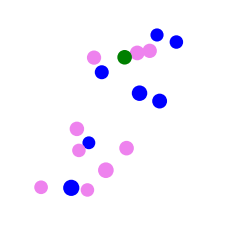

c_full ['blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'violet', 'violet', 'green', 'violet', 'blue', 'blue', 'blue', 'blue', 'violet', 'blue', 'violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'violet'
 'green' 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'violet'
 'green' 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'violet'
 'green' 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'violet'
 'green' 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'violet'
 'green' 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet

/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


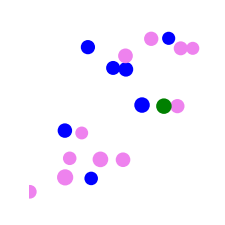

c_full ['violet', 'blue', 'violet', 'blue', 'blue', 'blue', 'green', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'violet', 'blue', 'violet', 'violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'green' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'green' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'green' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'green' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'blue' 'blue' 'green' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' '

<IPython.core.display.Javascript object>


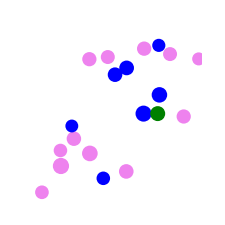

c_full ['violet', 'violet', 'violet', 'blue', 'violet', 'violet', 'violet', 'blue', 'blue', 'violet', 'blue', 'green', 'blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue'
 'blue' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue'
 'blue' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue'
 'blue' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue']
c ['blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue'
 'blue' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue'
 'blue' 'violet' 'blue' '

<IPython.core.display.Javascript object>


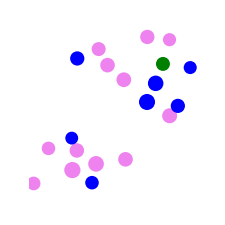

c_full ['violet', 'blue', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'violet', 'violet', 'blue', 'blue', 'violet', 'blue', 'violet', 'violet', 'violet', 'green', 'violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'green' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'green' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'green' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'green' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'blue' 'violet' 'violet' 'viole

<IPython.core.display.Javascript object>


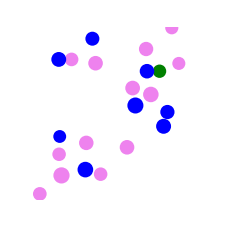

c_full ['blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'violet', 'blue', 'violet', 'violet', 'violet', 'blue', 'blue', 'violet', 'violet', 'violet', 'blue', 'blue', 'violet', 'green']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'blue'
 'violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'blue' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'blue'
 'violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'blue' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'blue'
 'violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'blue' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'violet' 'violet' 'blue'
 'violet' 'violet' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet'
 'blue' 'blue' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'violet' 'vio

<IPython.core.display.Javascript object>


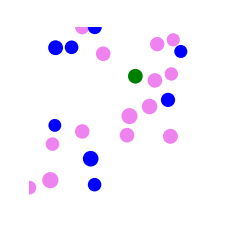

c_full ['violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet', 'green', 'blue', 'violet', 'blue']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'blue' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue'
 'violet' 'green' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'blue' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue'
 'violet' 'green' 'blue' 'violet' 'blue']
c ['violet']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'blue' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue'
 'violet' 'green' 'blue' 'violet' 'blue']
c ['green']
prev_c ['violet' 'violet' 'violet' 'blue' 'violet' 'blue' 'violet' 'violet'
 'violet' 'blue' 'violet' 'blue' 'blue' 'violet' 'violet' 'violet' 'blue'
 'violet' 'green' 'blue' 

<IPython.core.display.Javascript object>


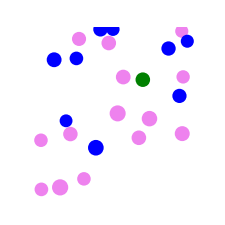

c_full ['violet', 'violet', 'green', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'blue', 'violet', 'blue', 'violet', 'blue', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet']
prev_c ['violet' 'violet' 'green' 'violet' 'violet' 'blue' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'violet' 'green' 'violet' 'violet' 'blue' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'violet' 'violet' 'blue' 'violet']
c ['blue']
prev_c ['violet' 'violet' 'green' 'violet' 'violet' 'blue' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'violet' 'blue'
 'blue' 'violet' 'violet' 'violet' 'blue' 'violet']
c ['violet']
prev_c ['violet' 'violet' 'green' 'violet' 'violet' 'blue' 'violet' 'violet'
 'blue' 'violet' 'violet' 'blue' 'blue' 'violet' 'blue' 'viole

<IPython.core.display.Javascript object>


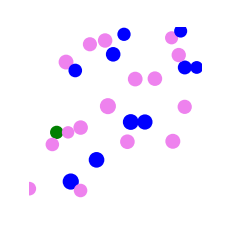

c_full ['violet', 'blue', 'violet', 'blue', 'violet', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'violet', 'violet', 'violet', 'blue', 'violet', 'blue', 'green', 'violet', 'blue', 'violet', 'violet', 'blue', 'blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'violet'
 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'violet'
 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'violet'
 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'blue' 'violet' 'blue'
 'green' 'violet' 'blue' 'violet' 'violet' 'blue' 'blue']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'blue' 'violet' 'violet' 'violet' 'violet'
 'blue' 'violet' 'blue' 'violet' '

<IPython.core.display.Javascript object>


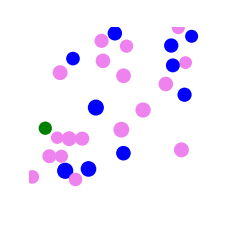

c_full ['violet', 'blue', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'violet', 'violet', 'blue', 'green', 'blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'blue', 'blue', 'blue', 'blue', 'violet', 'violet', 'violet', 'violet', 'violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'violet' 'blue'
 'violet' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet' 'violet' 'violet'
 'violet']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'violet' 'blue'
 'violet' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet' 'violet' 'violet'
 'violet']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'blue' 'violet' 'violet' 'blue'
 'violet' 'violet' 'blue' 'green' 'blue' 'blue' 'violet' 'violet' 'violet'
 'violet' 'blue' 'blue' 'blue' 'blue' 'violet' 'violet' 'violet' 'violet'
 'violet']
c ['violet']
prev

In [21]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(26):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [9]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)

0 [array([], dtype=float64)]
1 [array([0.19248497, 0.25975571, 0.32760233, 0.34247211, 0.35905958,
       0.34852288, 0.29181408, 0.2659962 , 0.25764277, 0.21029282,
       0.14866904, 0.1724263 , 0.10712052, 0.16533869, 0.22757858])]
2 [array([0.65420842, 0.5927949 , 0.54577047, 0.57281258, 0.60026064,
       0.66556641, 0.70424997])]
3 [array([0.48286573, 0.41296594, 0.48184213, 0.432893  , 0.36393952,
       0.39138757, 0.41010724, 0.45547637, 0.3901706 , 0.37358313,
       0.44085387, 0.42857796])]
4 [array([0.71549531, 0.69550511, 0.74252954, 0.81106932])]
5 [array([0.78899531, 0.8280454 , 0.86524765, 0.87882292, 0.81320499,
       0.83778944, 0.88349329, 0.9203215 , 0.90804558, 0.9071642 ,
       0.89837338, 0.88264351, 0.81317036, 0.88090717, 0.89877606,
       0.90493794])]
6 [array([0.82477629, 0.88442077, 0.92704863, 0.88873314, 0.95689304,
       0.98951368, 0.92831287, 0.9842365 , 0.92140271, 0.88570535])]
7 [array([0.90195129, 0.95090042, 0.88305381, 0.81510007, 0.74568227